### <b> Problem Statement: </b>
#### Use variational autoencoder (VAE) with Tensorflow and Keras to generate new images using functional modeling

#### <b> Objective: </b>
#### Generate images of MNIST with Tensorflow and Keras with Functional style of modeling technique

### MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized (28x28 pixels) and centered with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

### Sequential vs. Functional Modeling

In sequential model, you can only stack one layer after another. In functional model, you can connect one layer to literally any other layer.


### Note:

* We need to disable **eager mode** in TensorFlow V2 to train this specific neural network.

* We need to run **tf.executing_eagerly()** at the end to check if it returns **False** which indicates that the eager mode has been completely disabled.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
tf.compat.v1.disable_eager_execution()

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist

np.random.seed(25)
print("Eager Mode Active :",tf.executing_eagerly())

%matplotlib inline

Eager Mode Active : False


### Image dataset preprocessing
* The variables **X_train** and **X_test** will store all the images
* The variables **Y-train** and **Y_test** will store the ground truths (or labels)

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

* Code to show images from X_train array taken from index 120 to 129

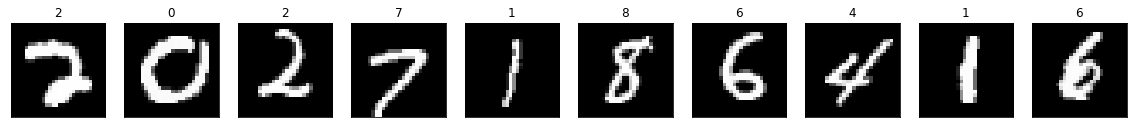

In [ ]:
fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0
for i in range(120, 130):
    axes[counter].set_title(y_train[i])
    axes[counter].imshow(X_train[i], cmap='gray')
    axes[counter].get_xaxis().set_visible(False)
    axes[counter].get_yaxis().set_visible(False)
    counter += 1
plt.show()

* Dividing all elements in the array by 255 to normalize the values representing the brightness of each pixel in a way that they lie within the range of 0 to 1 instead of 0 to 255.

In [ ]:
X_train = X_train/255
X_test = X_test/255

* Check the shape of both **X_train** and **X_test**

In [ ]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


* Reshape both **X_train** and **X_test** by applying `reshape()` method as we need a new axis to represents a single color channel, which is needed when we employ convolution layers (Conv2D layers) in our VAE network.

In [ ]:
# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

* Check the new shape of both **X_train** and **X_test**

In [ ]:
print(X_train_new.shape)
print(X_test_new.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Constructing encoder

* Defining some variables for future reusability in various tasks of the neural network

* Define the input shape for the first layer, taking values directly from image data shape
    
* Define latent space with two dimensions for future use and display the digit image distribution in a standard scatter plot

In [ ]:
img_height   = X_train_new.shape[1]    # 28
img_width    = X_train_new.shape[2]    # 28
num_channels = X_train_new.shape[3]    # 1

input_shape =  (img_height, img_width, num_channels)   # (28,28,1)

latent_dim = 2    # Dimension of the latent space

#### Note: 
* Here, instead of using **sequential model**, we are going to use **functional** style because you can only stack one layer after another in sequential model while you can connect a layer to literally any other layer in functional model.

In [ ]:
# Creating a functional model
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

#### Observation:
> 1. In the above functional model, the input layer is followed by two convolution layers which are expected to be able to extract more features in image data.
>
> 2. The convolution layers are connected to flatten layer in order to reshape all data into a single, one-dimensional array. 
>
> 3. These flatten layers are then connected to mu and sigma layers where each of these have two neurons.

#### Determining the values in the latent space layer:

* Defining a custom function called **compute_latent()** to determine the values in the latent space layer

In [ ]:
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

* **Reparameterization Trick:** <br/>
    The above function called **compute_latent()** will now be applied to Lambda layer to compute values passed from mu and sigma with special operation.

In [ ]:
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

[2021-02-19 13:54:34.119 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:347 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-02-19 13:54:34.269 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:347 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


* Saving the shape of convolution layer in variable called **conv_shape** to  apply it at the Conv2D layer in the decoder

In [ ]:
conv_shape = K.int_shape(encoder_conv)
conv_shape

(None, 14, 14, 16)

### Constructing decoder

* The decoder is like the inverse of encoder.

* In encoder we started with input shape as (28, 28 , 1) which outputs a value with the shape of (2,).

* However, in decoder, we will use the input shape as (2,) which will output an image with the shape (28, 28, 1).

In [ ]:
decoder_input = Input(shape=(latent_dim,))

decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)

decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)

decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)

decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)

decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

#### Note:

* The convolution layer used in decoder is Conv2DTranspose which does the inverse transformation of the standard Conv2D layer.

* The last Conv2DTranspose layer acts as the output of the decoder where the filters argument has to be 1 (already stored in num_channels variable) needed for reshaping back to the original image dimension (28, 28, 1).

### Connecting the encoder and decoder

* To build the **encoder** and **decoder**, we need to pass the input and output layer to the **Model()** function and use the **summary()** method to get the model summary.

In [ ]:
encoder = Model(encoder_input, latent_space)
encoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dense (Dense)                   (None, 2)            6274        flatten[0][0]                    
_______________________________________________________________________________________

In [ ]:
decoder = Model(decoder_input, decoder_conv)
decoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 8)         1160      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         73        
Total params: 10,641
Trainable params: 10,641
Non-trainable params: 0
_________________________________________________________________


### Linking the **encoder** and **decoder** in order to construct the entire VAE

* The logic used here is that the output of **VAE Model** is the output of the **decoder** in which its input is taken from the output of the **encoder**.

In [ ]:
vae = Model(encoder_input, decoder(encoder(encoder_input)))
vae.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 2)                 12708     
_________________________________________________________________
functional_3 (Functional)    (None, 28, 28, 1)         10641     
Total params: 23,349
Trainable params: 23,349
Non-trainable params: 0
_________________________________________________________________


#### Obesrvation:
> 1. We now have three models which can be trained using the **fit()** method to the connecting model (VAE)

> 2. In VAE summary figure, we need to ensure that `the shape of input and output layer has to be exactly the same` since `in the case of autoencoders the target or ground truth is taken from the original image itself`.

### Defining loss function and compiling model
* The standard loss functions like categorical cross entropy and RMSE (root mean square error) are not used by VAEs.

* A combination of **binary cross entropy loss** and **Kullback-Leibler divergence loss (KL loss)** is manually defined to be used with VAEs as there are no functions for this in Keras.

* We calculate the _overall loss_ from the **mean of the error values** of the two loss functions mentioned above.

In [ ]:
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

* Compiling the VAE model with the error function using **Adam Optimizer** as it usually performs better than others

In [ ]:
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

### Training the model

* Set the X samples as both x and y arguments as we want our reconstructed images to be as similar as the original ones.

* The loss value will decrease as the produced images get more identical to the actual value.

In [ ]:
history = vae.fit(x=X_train_new, y=X_train_new, epochs=20, batch_size=32, validation_data=(X_test_new,X_test_new))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
59648/60000 [============================>.] - ETA: 0s - loss: 191.9947WARNING:tensorflow:From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


60000/60000 [==============================] - 6s 101us/sample - loss: 191.8718 - val_loss: 169.8021
Epoch 2/20
60000/60000 [==============================] - 6s 99us/sample - loss: 168.2690 - val_loss: 167.4940
Epoch 3/20
60000/60000 [==============================] - 6s 99us/sample - loss: 166.5884 - val_loss: 166.5253
Epoch 4/20
60000/60000 [==============================] - 6s 99us/sample - loss: 165.3439 - val_loss: 164.7953
Epoch 5/20
60000/60000 [==============================] - 6s 98us/sample - loss: 164.1861 - val_loss: 163.6917
Epoch 6/20
60000/60000 [==============================] - 6s 99us/sample - loss: 163.2810 - val_loss: 163.0661
Epoch 7/20
60000/60000 [==============================] - 6s 98us/sample - loss: 162.6465 - val_loss: 162.7522
Epoch 8/20
60000/60000 [==============================] - 6s 98us/sample - loss: 162.1481 - val_loss: 162.2909
Epoch 9/20
60000/60000 [==============================] - 6s 98us/sample - loss: 161.7687 - val_loss: 161.7194
Epoch 10/20

### Analyzing the training process

* To analyze the training process, we will plot a graph between the loss value of the training and test data.

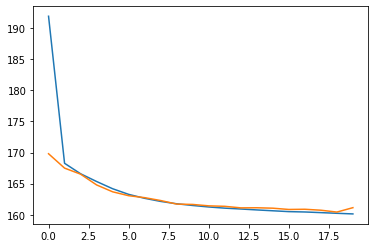

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#### Observation

> 1. The loss value of both train and test data are getting smaller until it stops at the value of around 161.

> 2. The loss value is already small enough as it starts to decrease slowly after several epochs.

> 3. This error might be lower if we increase the number of epochs. For now, the training has been pretty good so we will continue with the current training process.

### Displaying latent space

* Using **encoder** model to find out the location of each sample in latent space by applying **predict()** method

In [ ]:
encoded = encoder.predict(X_train_new)
encoded

array([[-0.02286677,  0.0465199 ],
       [-2.197846  ,  0.5528555 ],
       [ 0.42511037, -2.8199065 ],
       ...,
       [ 0.19123936, -0.08497598],
       [-0.79023945,  0.6916134 ],
       [-0.06154973,  0.96962637]], dtype=float32)

#### Observation

> 1. The encoded variable contains an array which holds the data points in latent space.

> 2. If we think of these values as bunch data points in a cartesian coordinate system, then we can say that the values in the first column represent the x-axis while those in the second represent the y-axis.

* Encode images into latent space and show the distribution using simple scatter plot

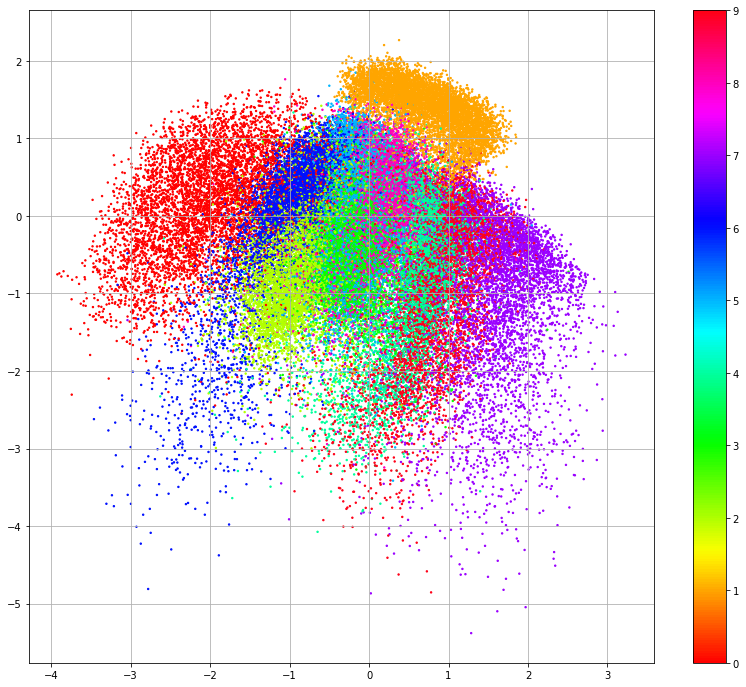

In [ ]:
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()

#### Observation
> 1. The different colors in the figure above show:
>
>   * **Orange:** Represents that at the upper side of the graph the digit 1 is distributed
>
>   * **Purple:** Repersents that a cluster of digit 7 is exactly located next to the number 1
>
>   * **Dark Blue:** Represents that at the right side of the graph the number 6 is distributed
>
>
> 2. The dots in the latent space are distributed according to their similarity. Due to this, the digits that are the same tend to be automatically clustered by this VAE.
>
> 3. The numbers 4 and 5 are becoming extremely similar to each other since the clusters of the two digits are indistinguishable in the latent space.
>
> 4. The distribution of number 0 and 1 (red at the bottom and orange) are pretty far from one another since this VAE thinks that these two digits look very different.
> 
> 5. The distribution in the latent space in the output graph is centered at (0,0) which is completely different to the one commonly obtain in traditional autoencoder.
>
> 6. The encoded samples in this VAE are distributed in such a way because of Kullback-Leibler divergence loss function (KL loss) which gives a higher error value for data points which lie far from the latent space origin.

### Decoding data points in latent space

* It is a custom function to take sequential points from latent space for creating an image sequence.

* Parameters required to run the below function are: starting point, end point, and number of images to decode.

* The core of decoding process: `new_images = decoder.predict(new_points)`


In [ ]:
def display_image_sequence(x_start,y_start,x_end,y_end,no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

#### 1. Displaying an image sequence starting from cluster of digit 1 and ending at cluster of digit 6

* We are taking some points between the two clusters to see the gradual changes between them. 

* The initial point taken is (0, 2) while the terminal point is (2, 0), and there are 7 other points between them (so we should get 9 images in total).

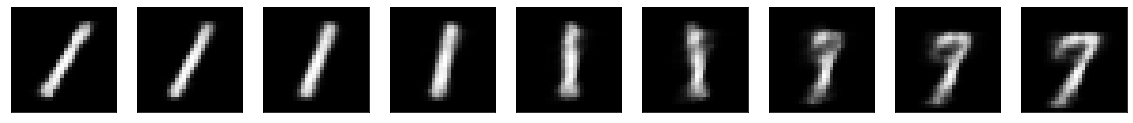

In [ ]:
# Starting point = (0,2), end point = (2,0)
display_image_sequence(0,2,2,0,9)

#### Observation
> * The leftmost image has the value of (0, 2) in latent space while the rightmost image is generated from a point in coordinate (2, 0). 
>
> * All other images are reconstructed based on values between the starting and end point considered for this sequence.

#### Note:

* This type of gradual change cannot be generated using a traditional autoencoder since it produces neither continuous nor complete latent space.


#### 2. Displaying an image sequence starting from cluster of digit 7 (purple) and ending at cluster of digit 1 (orange)

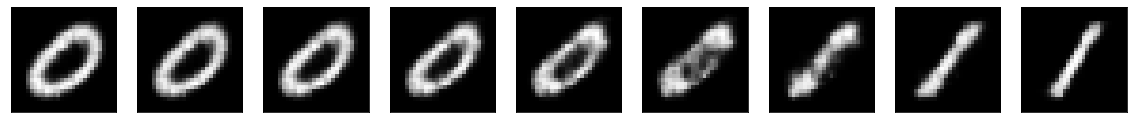

In [ ]:
# Starting point = (-2,1), end point = (0,2)
display_image_sequence(-2,1,0,2,9)

#### 3. Displaying an image sequence starting from (0, -2) up until (0, 2)

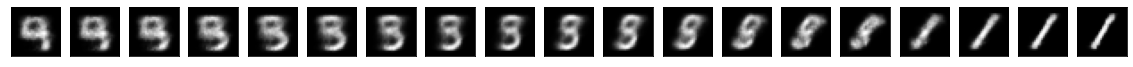

In [ ]:
# Starting point = (0,-2), end point = (0,2)
display_image_sequence(0,-2,0,2,19)

#### Observation
> 1. In the above output, the sequence gradually changes from digit zero, three(?), eight(?), and finally ends at one.
>
> 2. We have created a new image simply by picking up a new point in a latent space and employed the decoder to do the reconstruction. 

<br/>
